In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
import math

from costs import calculate_mse
from helpers import *
from grid_search import *
from plots import *

# Least squares and linear basis functions models

In [2]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    A = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(A, b)
    err = calculate_mse(y - tx.dot(w))
    
    return w, err

In [3]:
height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

w_ls, err_ls = least_squares(y, tx)

print(type(w_ls))
print(w_ls)
print(err_ls)

<class 'numpy.ndarray'>
[73.293922   13.47971243]
15.3858878688294


In [4]:
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    w0, w1 = generate_w(num_intervals=50)
    
    losses_gs = grid_search(y, tx, w0, w1)
    _, w0_gs, w1_gs = get_best_parameters(w0, w1, losses_gs)
    w_gs = np.array([w0_gs, w1_gs])
    
    w_ls, _ = least_squares(y, tx)
    
    return w_ls, w_gs, np.linalg.norm(w_ls-w_gs, 2)

w_ls, w_gs, err = test_your_least_squares()
print(w_ls)
print(w_gs)
print(err)

[73.293922   13.47971243]
[71.42857143 15.30612245]
2.610614161722826


## Least squares with a linear basis function model - Polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    phi = np.ones(len(x))
    phi = np.vstack((phi, [x**(j+1) for j in range(degree)]))
    
    return phi.T

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737484
Processing 3th experiment, degree=7, rmse=0.24965870360907327
Processing 4th experiment, degree=12, rmse=0.24328247483727994


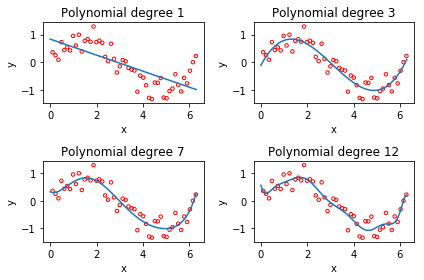

In [7]:
def polynomial_regression(x, y):
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        phi = build_poly(x, degree)
        weight, mse_err = least_squares(y, phi)
        rmse = np.sqrt(2*mse_err)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weight, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()


polynomial_regression(x, y)

# Evaluating model predication performance

In [8]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    np.random.seed(seed)
    N = np.shape(x)[0]
    idx = np.random.permutation(N)
    tr_size = int(np.floor(N*ratio))
    idx_tr = idx[:tr_size]
    idx_te = idx[tr_size:]
    
    x_tr = x[idx_tr]
    x_te = x[idx_te]
    y_tr = y[idx_tr]
    y_te = y[idx_te]
    
    return x_tr, x_te, y_tr, y_te

In [9]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed=seed)
    
    phi_tr = build_poly(x_tr, degree)
    phi_te = build_poly(x_te, degree)
    
    w_tr, mse_err_tr = least_squares(y_tr, phi_tr)
    
    rmse_tr = np.sqrt(2 * mse_err_tr)
    rmse_te = np.sqrt(2 * calculate_mse(y_te - phi_te.dot(w_tr)))

    print("proportion={p}, degree={d}, Training RMSE={tr:.6f}, Testing RMSE={te:.6f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

    
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.493816, Testing RMSE=0.181288
proportion=0.9, degree=3, Training RMSE=0.264219, Testing RMSE=0.206370
proportion=0.9, degree=7, Training RMSE=0.253810, Testing RMSE=0.219645
proportion=0.9, degree=12, Training RMSE=0.241829, Testing RMSE=0.249514
proportion=0.5, degree=1, Training RMSE=0.454647, Testing RMSE=0.530808
proportion=0.5, degree=3, Training RMSE=0.238683, Testing RMSE=0.296444
proportion=0.5, degree=7, Training RMSE=0.232298, Testing RMSE=0.284104
proportion=0.5, degree=12, Training RMSE=0.205028, Testing RMSE=1.548442
proportion=0.1, degree=1, Training RMSE=0.427641, Testing RMSE=0.534064
proportion=0.1, degree=3, Training RMSE=0.085364, Testing RMSE=0.459878
proportion=0.1, degree=7, Training RMSE=0.000000, Testing RMSE=2.259347
proportion=0.1, degree=12, Training RMSE=0.000000, Testing RMSE=4.637152


# Ridge Regression

In [10]:
np.logspace(-5, 0, 15)

array([1.00000000e-05, 2.27584593e-05, 5.17947468e-05, 1.17876863e-04,
       2.68269580e-04, 6.10540230e-04, 1.38949549e-03, 3.16227766e-03,
       7.19685673e-03, 1.63789371e-02, 3.72759372e-02, 8.48342898e-02,
       1.93069773e-01, 4.39397056e-01, 1.00000000e+00])

In [11]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    A = tx.T.dot(tx) + 2*lamb*np.shape(tx)[0]*np.eye(np.shape(tx)[1])
    b = tx.T.dot(y)
    w = np.linalg.solve(A, b)
    mse_err = calculate_mse(y - tx.dot(w))
    
    return w, mse_err

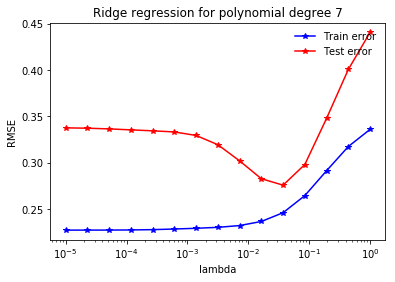

In [13]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed=seed)
    
    phi_tr = build_poly(x_tr, degree)
    phi_te = build_poly(x_te, degree)
    
    rmse_tr = []
    rmse_te = []
    
    for ll in lambdas:
        w_tr, mse_err_tr = ridge_regression(y_tr, phi_tr, ll)
        
        rmse_tr.append(np.sqrt(2 * mse_err_tr))
        rmse_te.append(np.sqrt(2 * calculate_mse(y_te - phi_te.dot(w_tr))))
        
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    

seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)